In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from prettytable import PrettyTable, TableStyle
import joblib

# Load data, perform imputation and train test split

In [2]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    if option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    return df

tentative_df = load_data()

In [3]:
tentative_df["social_vs_security"]=(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])/(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])
tentative_df["security_vs_social"]=(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])/(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])
feature_0=['Population','clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio', 'median_age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value',
       'house_affordability', 'uninsured_rate',
       'high_school_rate', 'dropout_rate', 'public_school_rate',
        "social_vs_security", "security_vs_social"] #'adherent_rate', 'rdm',
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']
crime_dataframe=tentative_df[['County', 'Year',  'crime_rate']+feature_0+feature_cat]
crime_dataframe=crime_dataframe.set_index(['County', 'Year'])
crime_dataframe.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985                NaN              NaN           NaN          NaN   
        1986                NaN              NaN           NaN          NaN   
        1987                NaN              NaN           NaN          NaN   
        1988                NaN              NaN           NaN          NaN   
        1989                NaN              NaN           NaN          NaN   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985                  NaN                NaN  ...   
        1986                  NaN                NaN  ...   
        1987                  NaN                NaN  ...   
        1988                  NaN                NaN  ...   
        1989                  NaN                NaN  ...   

              house_affordability  uninsured_rate  high_school_rate  \
County  Year                                                          
Alameda 1985                  NaN             NaN               NaN   
        1986                  NaN             NaN               NaN   
        1987                  NaN             NaN               NaN   
        1988                  NaN             NaN               NaN   
        1989                  NaN             NaN               NaN   

              dropout_rate  public_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985           NaN                 NaN                 NaN   
        1986           NaN                 NaN                 NaN   
        1987           NaN                 NaN                 NaN   
        1988           NaN                 NaN                 NaN   
        1989           NaN                 NaN                 NaN   

              security_vs_social  Category_Rural  Category_Suburban  \
County  Year                                                          
Alameda 1985                 NaN               0                  0   
        1986                 NaN               0                  0   
        1987                 NaN               0                  0   
        1988                 NaN               0                  0   
        1989                 NaN               0                  0   

              Category_Urban  
County  Year                  
Alameda 1985               1  
        1986               1  
        1987               1  
        1988               1  
        1989               1  

[5 rows x 33 columns]

In [4]:
crime_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2262 entries, ('Alameda', 1985) to ('Yuba', 2023)
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   crime_rate                    2262 non-null   float64
 1   Population                    2262 non-null   int64  
 2   clearance_rate                2262 non-null   float64
 3   population_density            2262 non-null   float64
 4   unemployment_rate             1914 non-null   float64
 5   adjusted_income               928 non-null    float64
 6   poverty_rate                  870 non-null    float64
 7   rent_burden                   812 non-null    float64
 8   home_ownership_rate           812 non-null    float64
 9   mobile_home_ratio             812 non-null    float64
 10  vacancy_rate                  812 non-null    float64
 11  Number_of_Persons_per_HseHld  812 non-null    float64
 12  renter_ratio                  812 no

In [5]:
Final={}
Final["dropna"]=crime_dataframe.dropna()
Final["dropna"].shape

(624, 33)

Imputation

In [6]:
# 1. Copy your original DataFrame and set a MultiIndex
df = crime_dataframe.copy()
#df = df.set_index(['County', 'Year'])

def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level='Year')
    
    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()
            
            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue
            
            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values('Year').values.reshape(-1, 1)
            y = valid_data.values
            
            # Fit the linear regression model
            model = LinearRegression().fit(X, y)
            
            # Predict for all years in this county
            X_all = group.index.get_level_values('Year').values.reshape(-1, 1)
            y_pred = model.predict(X_all)
            
            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]
        else:
            print(f"Skipping non-numeric column: {col}")
    
    return group

# 2. Group by County and apply the regression-based filling
df_reg_filled = (
    df.groupby(level='County', group_keys=False)
      .apply(fill_missing_with_linear_regression)
)

#df_reg_filled.head()

In [7]:
final_dataframe = df_reg_filled
#print(final_dataframe.isna().sum())
print(final_dataframe.shape)
final_dataframe=final_dataframe.dropna()
print(final_dataframe.shape)
Final["imputed"]=final_dataframe

(2262, 33)
(2108, 33)


In [8]:
print(np.var(final_dataframe['crime_rate']))
# Group by county and compute the variance of crime_rate for each county,
# then compute the average variance across all counties.
county_variances = final_dataframe.groupby(level="County")["crime_rate"].var()
avg_county_variance = county_variances.mean()
print("Average variance of crime_rate by county:", avg_county_variance)

# Group by year and compute the variance of crime_rate for each year,
# then compute the average variance across all years.
year_variances = final_dataframe.groupby(level="Year")["crime_rate"].var()
avg_year_variance = year_variances.mean()
print("Average variance of crime_rate by year:", avg_year_variance)


6.163726529166426e-06
Average variance of crime_rate by county: 3.7796157807726586e-06
Average variance of crime_rate by year: 5.260953083223783e-06


In [9]:
def Poly_df_function(df0):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    Poly_data = poly.fit_transform(df0)
    feature_names = poly.get_feature_names_out(input_features=df0.columns)
    Poly_df = pd.DataFrame(Poly_data, columns=feature_names, index=df0.index)
    return Poly_df

In [10]:
# For these dictionaries, keys are dropna/imputed, All/Urban/Suburban/Rural, and values are the corresponding DataFrames
X_train_dt={}
X_test_dt={}
y_train_dt={}
y_test_dt={}
X_train_Poly_dt={}
X_test_Poly_dt={}

In [11]:
for key in Final.keys():
    for key1 in ["All", "Urban", "Suburban", "Rural"]:
        if key1 == "All":
            df = Final[key]
        else:
            df = Final[key][Final[key]["Category_"+key1] == 1]

        # Split the data into features and target
        X = df[feature_0]
        y = df["crime_rate"]
        PolyX=Poly_df_function(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test, X_train_Poly, X_test_Poly = train_test_split(X, y, PolyX, test_size=0.15, random_state=42,shuffle=True)

        # Store the results in the dictionaries
        X_train_dt[(key,key1)] = X_train
        X_test_dt[(key,key1)] = X_test
        y_train_dt[(key,key1)] = y_train
        y_test_dt[(key,key1)] = y_test
        X_train_Poly_dt[(key,key1)] = X_train_Poly
        X_test_Poly_dt[(key,key1)] = X_test_Poly

In [12]:
import numpy as np

def train_test_split_by_county(X, y, X_poly, test_size=0.15, random_state=42):
    # Extract unique counties from the MultiIndex (assumed to have level "County")
    counties = np.array(X.index.get_level_values("County").unique())
    np.random.seed(random_state)
    
    # Shuffle and split counties
    n_counties = len(counties)
    n_test = int(np.floor(test_size * n_counties))
    shuffled = np.random.permutation(counties)
    test_counties = shuffled[:n_test]
    train_counties = shuffled[n_test:]
    
    # Create masks for train and test based on counties
    train_mask = X.index.get_level_values("County").isin(train_counties)
    test_mask = X.index.get_level_values("County").isin(test_counties)
    
    # Subset the data using the masks
    X_train = X[train_mask]
    X_test  = X[test_mask]
    y_train = y[train_mask]
    y_test  = y[test_mask]
    X_poly_train = X_poly[train_mask]
    X_poly_test  = X_poly[test_mask]
    
    return X_train, X_test, y_train, y_test, X_poly_train, X_poly_test

# Now apply the function for each dataset:
#X_train_Urban, X_test_Urban, y_train_Urban, y_test_Urban, X_train_Poly_Urban, X_test_Poly_Urban = train_test_split_by_county(
#    X_Urban, y_Urban, X_Poly_Urban, test_size=0.15, random_state=42
#)

#X_train_Suburban, X_test_Suburban, y_train_Suburban, y_test_Suburban, X_train_Poly_Suburban, X_test_Poly_Suburban = train_test_split_by_county(
#    X_Suburban, y_Suburban, X_Poly_Suburban, test_size=0.15, random_state=42
#)

#X_train_Rural, X_test_Rural, y_train_Rural, y_test_Rural, X_train_Poly_Rural, X_test_Poly_Rural = train_test_split_by_county(
#    X_Rural, y_Rural, X_Poly_Rural, test_size=0.15, random_state=42
#)


In [13]:
#print(X_train_Urban.index.get_level_values('County').unique())
#print(X_test_Urban.index.get_level_values('County').unique())

# Codes

In [14]:
from prettytable import PrettyTable, TableStyle

def print_table(model_stats):
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score", "MR2"]
    
    for model_name, stats in model_stats.items():
        first_row = True
        for cv_type, metrics in stats.items():
            if len(metrics) == 3:
                mse, rmse, r2 = metrics
                mr2 = ""
            elif len(metrics) == 4:
                mse, rmse, r2, mr2 = metrics
            else:
                mse, rmse, r2, mr2 = metrics[0], metrics[1], metrics[2], metrics[3] if len(metrics) > 3 else ""
            
            if first_row:
                table.add_row([model_name, cv_type, mse, rmse, r2, mr2])
                first_row = False
            else:
                table.add_row(["", cv_type, mse, rmse, r2, mr2])
        # Divider row between models
        table.add_row([""] * 6)
    
    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)


In [15]:
from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def deep_cross_fit1(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit models and compute performance statistics using several cross-validation schemes:
      - Regular (KFold) CV on the training set.
      - County-based CV using leave-one-county-out (splitting by the 'County' level of the index).
      - Time-series CV (using data until 2018 for training and data after 2018 for validation).
      - Test set performance (after fitting on the full training data).
    
    Modified R² (MR2) is defined as:
       MR2 = 1 - (MSE on split) / (Var(y) computed on the entire X_train)
    
    Parameters:
      X_train (pd.DataFrame): Training features (MultiIndex with levels "County" and "Year")
      X_test (pd.DataFrame): Test features (MultiIndex with levels "County" and "Year")
      y_train (pd.DataFrame or pd.Series): Training targets (indexed similarly)
      y_test (pd.DataFrame or pd.Series): Test targets
      models: Keyword arguments mapping model names to scikit-learn estimator instances.
      
    Returns:
      tuple:
         fitted_models: dict mapping model name to fitted model (trained on X_train)
         model_stats: dict mapping model name to a dictionary with keys:
             "Reg train", "Reg val", "County train", "County val", "Time train", "Time val", "Test"
             For each, the value is a list: [MSE, RMSE, r2, MR2]
         predictions: dict mapping model name to a dict with keys:
             "train": predictions on X_train,
             "test": predictions on X_test.
    """
    fitted_models = {}
    model_stats = {}
    predictions = {}
    
    # Compute the variance of y on the entire training set (sample variance)
    global_var = np.var(y_train, ddof=1)
    
    # For each model provided
    for key, model in models.items():
        stats = {}  # will hold our metrics for different CV schemes
        
        # 1. Regular KFold CV on training data
        reg_train_mse, reg_train_rmse, reg_train_r2, reg_train_mr2 = [], [], [], []
        reg_val_mse, reg_val_rmse, reg_val_r2, reg_val_mr2 = [], [], [], []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tt, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_tt, y_tt)
            train_preds = model_clone.predict(X_tt)
            val_preds = model_clone.predict(X_val)
            
            mse_train = mean_squared_error(y_tt, train_preds)
            reg_train_mse.append(mse_train)
            reg_train_rmse.append(root_mean_squared_error(y_tt, train_preds))
            reg_train_r2.append(r2_score(y_tt, train_preds))
            reg_train_mr2.append(1 - mse_train / global_var)
            
            mse_val = mean_squared_error(y_val, val_preds)
            reg_val_mse.append(mse_val)
            reg_val_rmse.append(root_mean_squared_error(y_val, val_preds))
            reg_val_r2.append(r2_score(y_val, val_preds))
            reg_val_mr2.append(1 - mse_val / global_var)
            
        stats["Reg train"] = [np.mean(reg_train_mse), np.mean(reg_train_rmse), np.mean(reg_train_r2), np.mean(reg_train_mr2)]
        stats["Reg val"]   = [np.mean(reg_val_mse), np.mean(reg_val_rmse), np.mean(reg_val_r2), np.mean(reg_val_mr2)]
        
        # 2. County cross-validation using Leave-One-County-Out
        logo = LeaveOneGroupOut()
        groups = X_train.index.get_level_values("County")
        county_train_mse, county_train_rmse, county_train_r2, county_train_mr2 = [], [], [], []
        county_val_mse, county_val_rmse, county_val_r2, county_val_mr2 = [], [], [], []
        for train_idx, val_idx in logo.split(X_train, y_train, groups):
            X_train_county = X_train.iloc[train_idx]
            y_train_county = y_train.iloc[train_idx]
            X_val_county   = X_train.iloc[val_idx]
            y_val_county   = y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_train_county, y_train_county)
            train_preds = model_clone.predict(X_train_county)
            val_preds   = model_clone.predict(X_val_county)
            
            mse_train = mean_squared_error(y_train_county, train_preds)
            county_train_mse.append(mse_train)
            county_train_rmse.append(root_mean_squared_error(y_train_county, train_preds))
            if len(y_train_county) < 2:
                county_train_r2.append(np.nan)
                county_train_mr2.append(np.nan)
            else:
                county_train_r2.append(r2_score(y_train_county, train_preds))
                county_train_mr2.append(1 - mse_train / global_var)
                
            mse_val = mean_squared_error(y_val_county, val_preds)
            county_val_mse.append(mse_val)
            county_val_rmse.append(root_mean_squared_error(y_val_county, val_preds))
            if len(y_val_county) < 2:
                county_val_r2.append(np.nan)
                county_val_mr2.append(np.nan)
            else:
                county_val_r2.append(r2_score(y_val_county, val_preds))
                county_val_mr2.append(1 - mse_val / global_var)
                
        stats["County train"] = [
            np.nanmean(county_train_mse), 
            np.nanmean(county_train_rmse), 
            np.nanmean(county_train_r2), 
            np.nanmean(county_train_mr2)
        ]
        stats["County val"] = [
            np.nanmean(county_val_mse), 
            np.nanmean(county_val_rmse), 
            np.nanmean(county_val_r2), 
            np.nanmean(county_val_mr2)
        ]
        
        # 3. Time series CV using data until 2018 for training and data after 2018 for validation.
        cutoff_year = 2018
        train_mask = X_train.index.get_level_values("Year") <= cutoff_year
        val_mask   = X_train.index.get_level_values("Year") > cutoff_year
        if train_mask.sum() > 0 and val_mask.sum() > 0:
            X_train_time = X_train[train_mask]
            y_train_time = y_train[train_mask]
            X_val_time   = X_train[val_mask]
            y_val_time   = y_train[val_mask]
            model_clone = clone(model)
            model_clone.fit(X_train_time, y_train_time)
            train_preds = model_clone.predict(X_train_time)
            val_preds   = model_clone.predict(X_val_time)
            
            mse_train = mean_squared_error(y_train_time, train_preds)
            time_train_mse = mse_train
            time_train_rmse = root_mean_squared_error(y_train_time, train_preds)
            time_train_r2 = r2_score(y_train_time, train_preds)
            time_train_mr2 = 1 - mse_train / global_var
            
            mse_val = mean_squared_error(y_val_time, val_preds)
            time_val_mse = mse_val
            time_val_rmse = root_mean_squared_error(y_val_time, val_preds)
            time_val_r2 = r2_score(y_val_time, val_preds)
            time_val_mr2 = 1 - mse_val / global_var
            
            stats["Time train"] = [time_train_mse, time_train_rmse, time_train_r2, time_train_mr2]
            stats["Time val"]   = [time_val_mse, time_val_rmse, time_val_r2, time_val_mr2]
        else:
            stats["Time train"] = [np.nan, np.nan, np.nan, np.nan]
            stats["Time val"]   = [np.nan, np.nan, np.nan, np.nan]
        
        # 4. Fit on full training set and compute test set performance.
        model.fit(X_train, y_train)
        fitted_models[key] = model
        test_preds = model.predict(X_test)
        test_mse   = mean_squared_error(y_test, test_preds)
        test_rmse  = root_mean_squared_error(y_test, test_preds)
        test_r2    = r2_score(y_test, test_preds)
        test_mr2   = 1 - test_mse / global_var
        stats["Test"] = [test_mse, test_rmse, test_r2, test_mr2]
        
        model_stats[key] = stats
        
        # Also store predictions on train and test for inspection.
        predictions[key] = {
            "train": model.predict(X_train),
            "test": test_preds
        }
        
    return fitted_models, model_stats, predictions


In [16]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import numpy as np

def compute_avg_MR2(S, X, y, model):
    """
    Computes the average modified R² (MR2) over leave-one-county-out splits.
    
    MR2 is defined as:
         MR2 = 1 - (MSE on validation set) / (Variance of y on the entire X)
         
    Parameters:
      S : set
          Set of feature names.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
    
    Returns:
      float
          The average MR2 over all LOCO splits.
    """
    if not S:
        return -np.inf  # if no features, MR2 is worst
    global_var = np.var(y, ddof=1)
    logo = LeaveOneGroupOut()
    groups = X.index.get_level_values("County")
    mr2_scores = []
    XX = X[list(S)]
    for train_idx, val_idx in logo.split(X, y, groups):
        X_tt, X_val = XX.iloc[train_idx], XX.iloc[val_idx]
        y_tt, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model_clone = clone(model)
        model_clone.fit(X_tt, y_tt)
        y_pred = model_clone.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mr2 = 1 - mse / global_var
        mr2_scores.append(mr2)
    return np.mean(mr2_scores)

def remove_features(S, X, y, model):
    """
    Recursively removes one feature at a time from set S if doing so improves the average MR2.
    
    Uses DFS to search through the removal space.
    
    Parameters:
      S : set
          Current set of features.
      X, y, model : as before.
      
    Returns:
      set
          The subset of S that yields a higher MR2.
    """
    current_avg = compute_avg_MR2(S, X, y, model)
    best = S.copy()
    for feat in list(S):
        new_set = S - {feat}
        if not new_set:  # skip if empty
            continue
        new_avg = compute_avg_MR2(new_set, X, y, model)
        if new_avg > current_avg:
            candidate = remove_features(new_set, X, y, model)
            candidate_avg = compute_avg_MR2(candidate, X, y, model)
            if candidate_avg > current_avg:
                best = candidate
                current_avg = candidate_avg
    return best

def add_features(S1, S2, X, y, model):
    """
    Recursively adds one feature at a time from S2 into S1 if doing so improves the average MR2.
    
    Uses DFS to search through the addition space.
    
    Parameters:
      S1 : set
          Current selected features.
      S2 : set
          Potential features to add.
      X, y, model : as before.
      
    Returns:
      set
          The augmented feature set that yields a higher MR2.
    """
    current_avg = compute_avg_MR2(S1, X, y, model)
    best = S1.copy()
    for feat in list(S2):
        new_set = S1 | {feat}
        new_avg = compute_avg_MR2(new_set, X, y, model)
        if new_avg > current_avg:
            remaining = S2 - {feat}
            candidate = add_features(new_set, remaining, X, y, model)
            candidate_avg = compute_avg_MR2(candidate, X, y, model)
            if candidate_avg > current_avg:
                best = candidate
                current_avg = candidate_avg
    return best

def Feature_selection(S, X, y, model):
    """
    Selects an optimal subset of features using a three-step DFS process:
      1) Removal: Remove features from S if doing so increases MR2.
      2) Addition: From the originally removed features, DFS to add features back if they improve MR2.
      3) Final Removal: Run the removal process again on the augmented set.
    
    Parameters:
      S : iterable
          The initial set (or list) of feature names.
      X : pd.DataFrame
          Training features with a MultiIndex (County, Year).
      y : pd.Series or pd.DataFrame
          Training target values.
      model : scikit-learn estimator
          The model to use for evaluation.
    
    Returns:
      set
          The final optimal subset of features.
    """
    # Convert S to a set
    S_initial = set(S)
    # Step 1: Removal phase
    S_removed = remove_features(S_initial, X, y, model)
    # Determine the features that were removed
    removed_features = S_initial - S_removed
    # Step 2: Addition phase
    S_added = add_features(S_removed, removed_features, X, y, model)
    # Step 3: Final removal phase
    #S_final = remove_features(S_added, X, y, model)
    return S_added


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def PCA_feature_selection(S, X, y, model, max_components=10):
    """
    Finds the optimal number of PCA components and optimal feature subset.
    
    For each n_components (starting at 1), it creates a pipeline:
         Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=n_components)), ("mod", model)])
    Then it calls Feature_selection(S, X, y, model_pipe) to select the best features
    and computes the average MR2 using leave-one-county-out CV (via compute_avg_MR2).
    
    It increases n_components by 1 until the average MR2 decreases; then, the previous
    setting is returned.
    
    Parameters:
      S : iterable
          The initial set of feature names.
      X : pd.DataFrame
          Training features with a MultiIndex (County, Year).
      y : pd.Series or pd.DataFrame
          Training target values.
      model : scikit-learn estimator
          The model to use (e.g., LinearRegression()).
      max_components : int, optional
          Maximum number of PCA components to try (default is 10).
    
    Returns:
      tuple: (best_n_components, best_feature_subset, best_avg_MR2)
    """
    best_mr2 = -np.inf
    best_n = None
    best_features = None
    
    # Loop over increasing PCA dimensions.
    for n in range(1, max_components + 1):
        # Create a pipeline with n_components in the PCA step.
        model_pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=n)),
            ("mod", model)
        ])
        
        # Run DFS-based feature selection with the current pipeline.
        selected_features = Feature_selection(S, X, y, model_pipe)
        # Compute average MR2 using leave-one-county-out CV.
        avg_mr2 = compute_avg_MR2(selected_features, X, y, model_pipe)
        print(f"n_components = {n}, selected features = {selected_features}, MR2 = {avg_mr2}")
        
        # If MR2 improves, update best values; if it drops, stop and return the previous best.
        if avg_mr2 > best_mr2:
            best_mr2 = avg_mr2
            best_n = n
            best_features = selected_features
        else:
            # MR2 has decreased; we assume the previous configuration was optimal.
            break
            
    return best_n, best_features#, best_mr2


In [18]:
def Poly_feature_selection(S, X, y, model):
    ll = list(S)
    N = len(ll)
    S0 = set(feature_0)
    # Iterate backward in steps of 10
    dd=25
    for i in range(0, N, dd):
        S0 = S0.union(set(ll[i:i+dd]))
        S1 = remove_features(S0, X, y, model)
        S0 = S1
    S0=S0.union(set(feature_0))
    S1=remove_features(S0, X, y, model)
    S0=S1
    return S0

In [19]:
def feature_importance(fitted_models,features,size):
    coeffs_mlr = fitted_models["mlr"].named_steps["Lin"].coef_
    sorted_indices_mlr = np.argsort(coeffs_mlr)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
    plt.title("Linear Regression Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_mlr[i]),features[i]) for i in sorted_indices_mlr]
    ll.sort(reverse=True)
    print('The top 4 important features in mlr is')
    for xx in ll[:4]:
        print(xx[1])

    coeffs_ridge = fitted_models["ridge"].named_steps['ridge'].coef_
    sorted_indices_ridge = np.argsort(coeffs_ridge)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge])
    plt.title("Ridge Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_ridge[i]),features[i]) for i in sorted_indices_ridge]
    ll.sort(reverse=True)
    print('The top 4 important features in ridge is')
    for xx in ll[:4]:
        print(xx[1])

    importance_xgb = fitted_models["xgb"].feature_importances_
    sorted_indices_xgb = np.argsort(importance_xgb)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
    plt.title("XGB Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_xgb[i]),features[i]) for i in sorted_indices_xgb]
    ll.sort(reverse=True)
    print('The top 4 important features in xgb is')
    for xx in ll[:4]:
        print(xx[1])


    importance_randomforest = fitted_models["random_forest"].named_steps["randomforest"].feature_importances_
    sorted_indices_randomforest = np.argsort(importance_randomforest)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_randomforest], importance_randomforest[sorted_indices_randomforest])
    plt.title("RandomForest Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_randomforest[i]),features[i]) for i in sorted_indices_randomforest]
    ll.sort(reverse=True)
    print('The top 4 important features in randomforest is')
    for xx in ll[:4]:
        print(xx[1])

In [20]:
def feature_importance_PCA(fitted_models, features, size, plot=True, models_to_use=None):
    """
    Compute and optionally plot feature importances (or effective coefficients) for different models.
    
    Parameters:
      fitted_models (dict): Dictionary containing fitted models.
      features (list): List of original feature names.
      size (tuple): Figure size for the plots.
      plot (bool): If True, plot the bar charts; if False, only print the top features.
      models_to_use (iterable): List or set of model names to consider. 
                                Defaults to all ["mlr", "ridge", "xgb", "random_forest"].
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if models_to_use is None:
        models_to_use = {"mlr", "ridge", "xgb", "random_forest"}
    else:
        models_to_use = set(models_to_use)
        
    # For MLR (Linear Regression) with PCA
    if "mlr" in models_to_use:
        scaler_mlr = fitted_models["mlr"].named_steps["scale"]
        pca_mlr = fitted_models["mlr"].named_steps["pca"]
        lin_mlr = fitted_models["mlr"].named_steps["Lin"]
        # Back-transform coefficients: effective_coef = (PCA.components_.T @ coef) / scaler.scale_
        eff_coef_mlr = (pca_mlr.components_.T.dot(lin_mlr.coef_)) / scaler_mlr.scale_
        sorted_indices_mlr = np.argsort(eff_coef_mlr)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_mlr], eff_coef_mlr[sorted_indices_mlr])
            plt.title("MLR Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_mlr[i]), features[i]) for i in sorted_indices_mlr]
        ll.sort(reverse=True)
        print("The top 4 important features in mlr are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For Ridge Regression with PCA
    if "ridge" in models_to_use:
        scaler_ridge = fitted_models["ridge"].named_steps["scale"]
        pca_ridge = fitted_models["ridge"].named_steps["pca"]
        ridge_model = fitted_models["ridge"].named_steps["ridge"]
        eff_coef_ridge = (pca_ridge.components_.T.dot(ridge_model.coef_)) / scaler_ridge.scale_
        sorted_indices_ridge = np.argsort(eff_coef_ridge)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_ridge], eff_coef_ridge[sorted_indices_ridge])
            plt.title("Ridge Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_ridge[i]), features[i]) for i in sorted_indices_ridge]
        ll.sort(reverse=True)
        print("The top 4 important features in ridge are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For XGB (assumed to be trained on original features)
    if "xgb" in models_to_use:
        importance_xgb = fitted_models["xgb"].feature_importances_
        sorted_indices_xgb = np.argsort(importance_xgb)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
            plt.title("XGB Feature Importance")
            plt.xlabel("Importance")
            plt.show()
        ll = [(importance_xgb[i], features[i]) for i in sorted_indices_xgb]
        ll.sort(reverse=True)
        print("The top 4 important features in xgb are:")
        for imp, feat in ll[:4]:
            print(feat)
    
    # For RandomForest with PCA in a pipeline:
    if "random_forest" in models_to_use:
        scaler_rf = fitted_models["random_forest"].named_steps["scale"]
        pca_rf = fitted_models["random_forest"].named_steps["pca"]
        rf_model = fitted_models["random_forest"].named_steps["randomforest"]
        # Heuristic: effective importance = abs(PCA.components_.T) dot tree_importances
        eff_importance_rf = np.abs(pca_rf.components_.T).dot(rf_model.feature_importances_)
        sorted_indices_rf = np.argsort(eff_importance_rf)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_rf], eff_importance_rf[sorted_indices_rf])
            plt.title("RandomForest Effective Feature Importance (Original Features)")
            plt.xlabel("Importance")
            plt.show()
        ll = [(eff_importance_rf[i], features[i]) for i in sorted_indices_rf]
        ll.sort(reverse=True)
        print("The top 4 important features in random forest are:")
        for imp, feat in ll[:4]:
            print(feat)


# Train models

In [21]:
fitted_models={}
models_stats={}
models_pred={}

# Uncomment this to perform feature selection again
#features={}

#Load selected features:
features = joblib.load("features.pkl")

In [22]:
key="imputed"
key1="Urban"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

#Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

imputed Urban model
Optimal subset of features:
13 ['adj_police_budget', 'unemployment_rate', 'adj_prison_budget', 'adj_health_budget', 'unemployment_rate vacancy_rate', 'home_ownership_rate', 'dropout_rate', 'Population uninsured_rate', 'adj_judiciary_budget', 'house_affordability', 'clearance_rate median_age', 'home_ownership_rate^2', 'adj_welfare_budget']
╔═══════════════╦══════════════╦════════════════════════╦════════════════════════╦══════════════════════╦═════════════════════╗
║     Model     ║     Type     ║          MSE           ║          RMSE          ║       r2 Score       ║         MR2         ║
╠═══════════════╬══════════════╬════════════════════════╬════════════════════════╬══════════════════════╬═════════════════════╣
║      mlr      ║  Reg train   ║ 3.1695718753353804e-06 ║ 0.0017801447172775258  ║  0.6221161718603111  ║  0.6234996902376992 ║
║               ║   Reg val    ║ 3.257858438638596e-06  ║  0.001802303835354169  ║  0.6002837039232641  ║  0.6130124952035143 ║

In [23]:
key="imputed"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

# Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

imputed Suburban model
Optimal subset of features:
25 ['rent_burden', 'adjusted_income', 'population_density uninsured_rate', 'adjusted_income public_school_rate', 'Population adj_welfare_budget', 'renter_ratio', 'rent_burden house_affordability', 'adj_rehab_budget', 'adjusted_income^2', 'median_age security_vs_social', 'unemployment_rate mobile_home_ratio', 'adj_health_budget', 'rent_burden^2', 'public_school_rate', 'adj_welfare_budget', 'mobile_home_ratio renter_ratio', 'unemployment_rate dropout_rate', 'house_affordability', 'clearance_rate adj_judiciary_budget', 'Population renter_ratio', 'adj_judiciary_budget', 'mobile_home_ratio social_vs_security', 'high_school_rate', 'adj_education_budget uninsured_rate', 'uninsured_rate security_vs_social']
╔═══════════════╦══════════════╦════════════════════════╦════════════════════════╦═════════════════════╦══════════════════════╗
║     Model     ║     Type     ║          MSE           ║          RMSE          ║       r2 Score      ║        

In [24]:
key="imputed"
key1="Rural"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

# Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

imputed Rural model
Optimal subset of features:
28 ['adj_education_budget', 'poverty_rate Number_of_Persons_per_HseHld', 'adj_welfare_budget adj_rehab_budget', 'median_age', 'home_ownership_rate', 'median_house_value', 'vacancy_rate', 'unemployment_rate median_house_value', 'mobile_home_ratio^2', 'vacancy_rate adj_welfare_budget', 'poverty_rate adj_rehab_budget', 'clearance_rate', 'median_age adj_rehab_budget', 'uninsured_rate', 'vacancy_rate house_affordability', 'adj_mental_health_budget^2', 'adj_health_budget', 'unemployment_rate uninsured_rate', 'adj_police_budget adj_mental_health_budget', 'unemployment_rate dropout_rate', 'mobile_home_ratio renter_ratio', 'adj_judiciary_budget', 'Number_of_Persons_per_HseHld', 'house_affordability', 'adj_judiciary_budget uninsured_rate', 'mobile_home_ratio social_vs_security', 'high_school_rate', 'adj_education_budget uninsured_rate']
╔═══════════════╦══════════════╦════════════════════════╦═══════════════════════╦═══════════════════════╦════════

In [25]:
key="dropna"
key1="Urban"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

# Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))

ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

dropna Urban model
Optimal subset of features:
16 ['Population', 'adjusted_income', 'adjusted_income public_school_rate', 'adj_mental_health_budget public_school_rate', 'mobile_home_ratio', 'clearance_rate', 'adjusted_income^2', 'dropout_rate public_school_rate', 'public_school_rate', 'adjusted_income home_ownership_rate', 'uninsured_rate^2', 'adj_judiciary_budget', 'adj_mental_health_budget', 'Population mobile_home_ratio', 'high_school_rate', 'adj_welfare_budget']
╔═══════════════╦══════════════╦════════════════════════╦════════════════════════╦═════════════════════╦═════════════════════╗
║     Model     ║     Type     ║          MSE           ║          RMSE          ║       r2 Score      ║         MR2         ║
╠═══════════════╬══════════════╬════════════════════════╬════════════════════════╬═════════════════════╬═════════════════════╣
║      mlr      ║  Reg train   ║ 3.643181985849938e-07  ║ 0.0006033870706262298  ║  0.8919727752446152 ║  0.8929567762803625 ║
║               ║   R

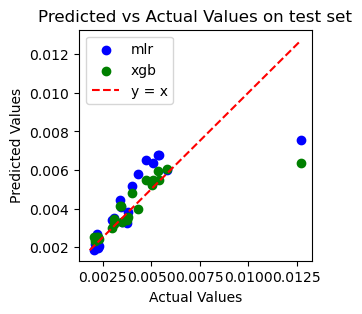

In [27]:
#Note that Test MR2 score is low because of one outlier point:
key="dropna"
key1="Urban"
plt.figure(figsize=(3, 3))
plt.scatter(y_test_dt[(key,key1)],models_pred[(key,key1)]['mlr']['test'], label="mlr",c="blue")
plt.scatter(y_test_dt[(key,key1)],models_pred[(key,key1)]['xgb']['test'], label="xgb",c="green")
#for x, y, label in zip(preda, ya, ya.index):
#    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha="center", fontsize=8)


# Plot the line y = x
x = np.linspace(min(y_test_dt[(key,key1)].min(), models_pred[(key,key1)]['mlr']['test'].min()), max(y_test_dt[(key,key1)].max(), models_pred[(key,key1)]['mlr']['test'].max()), 100)
plt.plot(x, x, color='red', linestyle='--', label="y = x")

# Add labels and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values on test set")
plt.legend()
plt.show()

In [28]:
key="dropna"
key1="Suburban"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

# Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))
ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

dropna Suburban model
Optimal subset of features:
13 ['adj_police_budget', 'Population', 'adj_health_budget', 'median_age adj_welfare_budget', 'adjusted_income median_house_value', 'dropout_rate', 'adj_judiciary_budget', 'median_house_value dropout_rate', 'adj_welfare_budget security_vs_social', 'dropout_rate social_vs_security', 'high_school_rate', 'adj_welfare_budget', 'renter_ratio adj_health_budget']
╔═══════════════╦══════════════╦════════════════════════╦════════════════════════╦═════════════════════╦═══════════════════════╗
║     Model     ║     Type     ║          MSE           ║          RMSE          ║       r2 Score      ║          MR2          ║
╠═══════════════╬══════════════╬════════════════════════╬════════════════════════╬═════════════════════╬═══════════════════════╣
║      mlr      ║  Reg train   ║ 1.1493032223766095e-06 ║  0.001071527504792154  ║  0.3781222912229464 ║   0.3835681865226568  ║
║               ║   Reg val    ║ 1.1987320058835956e-06 ║ 0.0010870152844011

In [29]:
key="dropna"
key1="Rural"
print(key+" "+key1+" model")

n_components = 5
models = {
    "mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("ridge", Ridge())]),
    "random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

# Uncomment this to perform feature selection again
#features[(key,key1)]=list(Poly_feature_selection(set(X_train_Poly_dt[(key,key1)].columns), X_train_Poly_dt[(key,key1)], y_train_dt[(key,key1)], models["mlr"]))
ff=features[(key,key1)]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[(key,key1)], models_stats[(key,key1)], models_pred[(key,key1)] = deep_cross_fit1(
    X_train_Poly_dt[(key,key1)][ff],X_test_Poly_dt[(key,key1)][ff], y_train_dt[(key,key1)],y_test_dt[(key,key1)], **models
)

# Using pretty table
print_table(models_stats[(key,key1)])

dropna Rural model
Optimal subset of features:
14 ['poverty_rate^2', 'rent_burden house_affordability', 'adj_rehab_budget', 'uninsured_rate', 'median_age', 'median_age security_vs_social', 'adj_education_budget adj_prison_budget', 'vacancy_rate', 'mobile_home_ratio renter_ratio', 'poverty_rate', 'unemployment_rate dropout_rate', 'adj_judiciary_budget', 'house_affordability', 'uninsured_rate security_vs_social']
╔═══════════════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦══════════════════════╗
║     Model     ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2          ║
╠═══════════════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬══════════════════════╣
║      mlr      ║  Reg train   ║ 1.959867666485674e-06  ║ 0.0013984854484549306 ║  0.4339689859621466 ║  0.4374643702249891  ║
║               ║   Reg val    ║ 2.138422121849968e-06  ║ 0.00144635250269653

In [30]:
# To save the dictionary
#joblib.dump(features, "features.pkl")

# To load it later
#features = joblib.load("features.pkl")


In [31]:
for key1 in ["Urban","Suburban","Rural"]:
    for key in ["imputed","dropna"]:
        print('\n')
        print(key+" "+key1+" model")
        # Can set plot=True to visualize the feature importances
        # Can modify models_to_use to include/exclude specific models
        feature_importance_PCA(fitted_models[(key,key1)],features[(key,key1)],(3,3), plot=False, models_to_use=['mlr'])



imputed Urban model
The top 4 important features in mlr are:
dropout_rate
adj_judiciary_budget
home_ownership_rate
home_ownership_rate^2


dropna Urban model
The top 4 important features in mlr are:
dropout_rate public_school_rate
mobile_home_ratio
uninsured_rate^2
clearance_rate


imputed Suburban model
The top 4 important features in mlr are:
adj_education_budget uninsured_rate
mobile_home_ratio renter_ratio
public_school_rate
renter_ratio


dropna Suburban model
The top 4 important features in mlr are:
dropout_rate
dropout_rate social_vs_security
adj_welfare_budget security_vs_social
adj_judiciary_budget


imputed Rural model
The top 4 important features in mlr are:
mobile_home_ratio^2
mobile_home_ratio renter_ratio
mobile_home_ratio social_vs_security
home_ownership_rate


dropna Rural model
The top 4 important features in mlr are:
mobile_home_ratio renter_ratio
uninsured_rate security_vs_social
uninsured_rate
adj_rehab_budget
